# <font color="#114b98">Anticipez les besoins en consommation de bâtiments</font>

## <font color="#114b98">Notebook de prédiction de la consommation totale d’énergie</font>

Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, notre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, nous voulons tenter de prédire **la consommation totale d’énergie de bâtiments non destinés à l’habitation** pour lesquels elles n’ont pas encore été mesurées.

## <font color="#114b98">Sommaire</font>
[1. Chargement du dataset](#section_1)

[2. Encodage avec OneHotEncoder et standardisation avec StandardScaler](#section_2)  

[3. Régression avec DummyRegressor](#section_3)   

[4. Régressions sans hyperparamétrage](#section_4)  

[5. Comparaison des régressions](#section_5)   

[6. Cross-Validation](#section_6)   

[7. Hyperparamétrage](#section_7) 

[8. Choix du meilleur modèle](#section_8)

[9. SHAP : SHapley Additive exPlanations](#section_9)

[10. Exemple de prédictions de consommation d'énergie](#section_10)

## <font color="#114b98" id="section_1">1. Chargement du dataset</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shap
%matplotlib inline

In [2]:
plt.rc('axes', titlesize=22)
plt.rc('axes', labelsize=18) 

In [3]:
# Séparateurs de jeu de données
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold

# Créations de pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Transformateurs de variables
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Régresseurs
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Métriques
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Cross validation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [4]:
sns.set()

In [5]:
plt.rc('axes', titlesize=22) 
plt.rc('axes', labelsize=18) 

In [6]:
path = 'N:/5 - WORK/1 - Projets/Projet 3/'
files = os.listdir(path)
files

['2016_Building_Energy_Benchmarking.csv',
 'Anticipez_les_besoins_en_consommation_de_bâtiments_Durand_Simon.zip',
 'data_seattle_clean.csv',
 'Durand_Simon_4_presentation_102022.pdf',
 'images',
 'ressources',
 'tutorats']

In [7]:
filename = files[2]

In [8]:
%%time
data = pd.read_csv(path+filename, sep=',', low_memory=False)

CPU times: total: 0 ns
Wall time: 11 ms


In [9]:
data.head()

,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,ElectricityProp,NaturalGasProp,SteamUseProp,BuildingAge,...,Senior Care Community,Small- and Mid-Sized Office,Social/Meeting Hall,Strip Mall,Supermarket/Grocery Store,Swimming Pool,Urgent Care/Clinic/Other Outpatient,Vocational School,Wholesale Club/Supercenter,Worship Facility
0,2.564949,11.390023,0.000000,60.0,15.824652,5.525373,0.529177,0.171177,0.268728,88,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.484907,11.547974,0.145453,61.0,15.974742,5.693261,0.374270,0.593813,0.000000,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.737670,13.770629,0.205748,43.0,18.118725,7.645053,0.669849,0.020204,0.291688,46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.397895,11.023878,0.000000,56.0,15.753792,5.660979,0.398590,0.260726,0.318772,89,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.944439,12.075856,0.353115,75.0,16.500395,6.226556,0.366295,0.600689,0.000000,35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
data.dtypes

NumberofFloors                         float64
PropertyGFATotal                       float64
PropertyGFAParking                     float64
ENERGYSTARScore                        float64
SiteEnergyUseWN(kBtu)                  float64
                                        ...   
Swimming Pool                          float64
Urgent Care/Clinic/Other Outpatient    float64
Vocational School                      float64
Wholesale Club/Supercenter             float64
Worship Facility                       float64
Length: 74, dtype: object

In [11]:
df = data.copy()

In [12]:
data.drop(['ENERGYSTARScore'], inplace=True, axis=1)

In [13]:
print("Le dataset compte {} lignes et {} colonnes.".format(data.shape[0], data.shape[1]))

Le dataset compte 1603 lignes et 73 colonnes.


In [14]:
print('Données manquantes (%) : ', data.isna().sum().sum()/(data.shape[0]*data.shape[1])*100)

Données manquantes (%) :  0.0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603 entries, 0 to 1602
Data columns (total 73 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   NumberofFloors                                        1603 non-null   float64
 1   PropertyGFATotal                                      1603 non-null   float64
 2   PropertyGFAParking                                    1603 non-null   float64
 3   SiteEnergyUseWN(kBtu)                                 1603 non-null   float64
 4   TotalGHGEmissions                                     1603 non-null   float64
 5   ElectricityProp                                       1603 non-null   float64
 6   NaturalGasProp                                        1603 non-null   float64
 7   SteamUseProp                                          1603 non-null   float64
 8   BuildingAge                                           1603

Je supprime la variable 'TotalGHGEmissions' qui ne sera pas utilisée dans ce notebook.

In [16]:
data = data[data.drop('TotalGHGEmissions', axis=1).columns]

In [17]:
print("Le dataset compte {} lignes et {} colonnes.".format(data.shape[0], data.shape[1]))

Le dataset compte 1603 lignes et 72 colonnes.


## <font color="#114b98" id="section_2">2. Encodage avec OneHotEncoder et standardisation avec StandardScaler</font>

In [18]:
num_columns = list(data.select_dtypes(include=['float64','int64']).drop(['SiteEnergyUseWN(kBtu)'], axis=1).columns)

In [19]:
transfo_num_columns = Pipeline(steps=[('standard', StandardScaler())])

In [20]:
obj_columns = list(data.select_dtypes(include=['object']).columns)

In [21]:
transfo_obj_columns = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [22]:
preparation = ColumnTransformer(
    transformers=[
        ('quantitative', transfo_num_columns , num_columns),
        ('qualitative', transfo_obj_columns , obj_columns)])

## <font color="#114b98" id="section_3">3. Régression avec DummyRegressor</font>

In [23]:
model_dummy = Pipeline(steps=[('preparation', preparation),
                      ('DummyRegressor', DummyRegressor())])

In [24]:
X = data[data.drop(['SiteEnergyUseWN(kBtu)'], axis=1).columns]

In [25]:
y = data[['SiteEnergyUseWN(kBtu)']]

In [26]:
X.shape

(1603, 71)

In [27]:
y.shape

(1603, 1)

Je sépare le jeu de données en un jeu d'entraînement (80%) et un jeu de test (20%).

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [29]:
preparation.fit_transform(X_train).shape

(1282, 71)

In [30]:
nn_input = preparation.fit_transform(X_train).shape[1]

In [31]:
X_train_view = pd.DataFrame(preparation.fit_transform(X_train))
X_train_view

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,0.065732,-0.137039,-0.438289,1.143660,-1.061591,-0.226643,0.051212,0.0,0.0,-0.071399,...,0.0,0.0,-0.080161,0.0,-0.162713,0.0,0.0,0.0,0.0,-0.203949
1,0.687791,1.585795,3.397246,0.892167,-0.748051,-0.226643,-0.846876,0.0,0.0,-0.071399,...,0.0,0.0,-0.080161,0.0,-0.162713,0.0,0.0,0.0,0.0,-0.203949
2,-0.997686,-0.219606,-0.438289,-0.313561,0.218626,-0.226643,-0.475253,0.0,0.0,-0.071399,...,0.0,0.0,-0.080161,0.0,-0.162713,0.0,0.0,0.0,0.0,-0.203949
3,0.065732,-1.153245,-0.438289,0.984391,-1.061591,-0.226643,1.011236,0.0,0.0,-0.071399,...,0.0,0.0,-0.080161,0.0,-0.162713,0.0,0.0,0.0,0.0,-0.203949
4,1.129150,1.542175,1.579658,1.195706,-1.061591,-0.226643,-0.723001,0.0,0.0,-0.071399,...,0.0,0.0,-0.080161,0.0,-0.162713,0.0,0.0,0.0,0.0,-0.203949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277,-0.997686,-0.323134,-0.438289,0.426786,-0.337459,-0.226643,0.082180,0.0,0.0,-0.071399,...,0.0,0.0,-0.080161,0.0,-0.162713,0.0,0.0,0.0,0.0,-0.203949
1278,-0.375626,-0.898733,-0.438289,-0.966707,1.171011,-0.226643,1.289953,0.0,0.0,-0.071399,...,0.0,0.0,-0.080161,0.0,-0.162713,0.0,0.0,0.0,0.0,-0.203949
1279,-0.375626,-0.913810,-0.438289,0.189369,-0.250404,-0.226643,1.320921,0.0,0.0,-0.071399,...,0.0,0.0,-0.080161,0.0,-0.162713,0.0,0.0,0.0,0.0,-0.203949
1280,-0.997686,-0.953113,-0.438289,-0.968979,0.919451,-0.226643,-1.218498,0.0,0.0,-0.071399,...,0.0,0.0,-0.080161,0.0,-0.162713,0.0,0.0,0.0,0.0,4.871143


In [32]:
print("Après utilisation de OneHotEncoder, X_train compte {} lignes et {} colonnes."\
      .format(preparation.fit_transform(X_train).shape[0], preparation.fit_transform(X_train).shape[1]))

Après utilisation de OneHotEncoder, X_train compte 1282 lignes et 71 colonnes.


In [33]:
y_train.max()

SiteEnergyUseWN(kBtu)    20.42494
dtype: float64

In [34]:
model_dummy.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('quantitative',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler())]),
                                                  ['NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'PropertyGFAParking',
                                                   'ElectricityProp',
                                                   'NaturalGasProp',
                                                   'SteamUseProp',
                                                   'BuildingAge',
                                                   'Adult Education',
                                                   'Automobile Dealership',
                                                   'Bank Branch',
                                      

In [35]:
y_pred = model_dummy.predict(X_test)

Je crée 4 dictionnaires dans lesquels je vais enregistrer les résultats de mes tests :
 - R² sur le jeu d'entraînement
 - R² sur le jeu de test
 - MAE : erreur absolue moyenne, moyenne arithmétique des valeurs absolues des écarts
 - RMSE : erreur quadratique moyenne : racine carrée de la moyenne des carrés des erreurs

In [36]:
train_scores = {} 
test_scores = {}
maes = {}
rmses = {}

In [37]:
def score(estimator):
    """Compute and print scores"""
    """Saves scores in dictionnaries"""
    train_score = estimator.score(X_train, y_train)
    test_score = r2_score(y_test,y_pred)
    mae = mean_absolute_error(y_test,y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    
    model_name = str(estimator.get_params).split(' ')[-2][2:-2]
    if model_name == '':
        model_name = str(estimator.get_params).split(' ')[-1][0:16]

    train_scores[model_name] = f"{train_score:.3f}"
    test_scores[model_name] = f"{test_score:.3f}"
    maes[model_name] = f"{mae:.3f}"
    rmses[model_name] = f"{rmse:.3f}"    
    
    print(f'\
            R² Train : {train_score} \n\
            R² Test : {test_score}\n\
            M.A.E. : {mae}\n\
            R.M.S.E. : {rmse}')

In [38]:
score(model_dummy)

            R² Train : 0.0 
            R² Test : -4.747036296626206e-05
            M.A.E. : 0.9987692068133799
            R.M.S.E. : 1.2737502935964349


## <font color="#114b98" id="section_4">4. Régressions sans hyperparamétrage</font>

### RandomForestRegressor

In [39]:
model_randomforest = Pipeline(steps=[('preparation', preparation),
                      ('RandomForest', RandomForestRegressor(random_state=0))])

In [40]:
model_randomforest.fit(X_train, y_train.values.ravel());

In [41]:
y_pred = model_randomforest.predict(X_test)

In [42]:
score(model_randomforest)

            R² Train : 0.9652583242109345 
            R² Test : 0.7237851326135973
            M.A.E. : 0.5028463541927171
            R.M.S.E. : 0.6694181986089314


### GradientBoostingRegressor

In [43]:
model_gradientboosting = Pipeline(steps=[('preparation', preparation),
                      ('GradientBoosting', GradientBoostingRegressor(random_state=0))])

In [44]:
model_gradientboosting.fit(X_train, y_train.values.ravel());

In [45]:
y_pred = model_gradientboosting.predict(X_test)

In [46]:
y_pred_best = model_gradientboosting.predict(X_test)

In [47]:
score(model_gradientboosting)

            R² Train : 0.8663119470998648 
            R² Test : 0.7483054228675756
            M.A.E. : 0.4804371995275197
            R.M.S.E. : 0.6390148026193392


### ElasticNet

In [48]:
model_elasticnet = Pipeline(steps=[('preparation', preparation),
                      ('ElasticNet', ElasticNet(random_state=0))])

In [49]:
model_elasticnet.fit(X_train, y_train.values.ravel());

In [50]:
y_pred = model_elasticnet.predict(X_test)

In [51]:
score(model_elasticnet)

            R² Train : 0.3380941100670035 
            R² Test : 0.3207546019589149
            M.A.E. : 0.8188875287497727
            R.M.S.E. : 1.049753525038363


### ExtraTreesRegressor

In [52]:
model_extratrees = Pipeline(steps=[('preparation', preparation),
                      ('ExtraTrees', ExtraTreesRegressor(random_state=0))])

In [53]:
model_extratrees.fit(X_train, y_train.values.ravel());

In [54]:
y_pred = model_extratrees.predict(X_test)

In [55]:
score(model_extratrees)

            R² Train : 1.0 
            R² Test : 0.7142852231085756
            M.A.E. : 0.496131753414261
            R.M.S.E. : 0.6808325964419297


### Support Vector Regression

In [56]:
model_supportvector = Pipeline(steps=[('preparation', preparation),
                      ('SupportVector', SVR())])

In [57]:
model_supportvector.fit(X_train, y_train.values.ravel());

In [58]:
y_pred = model_supportvector.predict(X_test)

In [59]:
score(model_supportvector)

            R² Train : 0.8173197850999334 
            R² Test : 0.7325985058628912
            M.A.E. : 0.47363495899791336
            R.M.S.E. : 0.6586518319714811


### AdaBoost

In [60]:
from sklearn.ensemble import AdaBoostRegressor

In [61]:
model_adaboost = Pipeline(steps=[('preparation', preparation),
                                 ('AdaBoost', AdaBoostRegressor(random_state=0))])

In [62]:
model_adaboost.fit(X_train, y_train.values.ravel());

In [63]:
y_pred = model_adaboost.predict(X_test)

In [64]:
score(model_adaboost)

            R² Train : 0.700916453175541 
            R² Test : 0.6300122935741646
            M.A.E. : 0.5935829161272222
            R.M.S.E. : 0.7747607953352678


### XGBoost

In [65]:
model_xgboost = Pipeline(steps=[('preparation', preparation),
                      ('XGBoost', XGBRegressor(random_state=0))])

In [66]:
model_xgboost.fit(X_train, y_train.values.ravel());

In [67]:
y_pred = model_xgboost.predict(X_test)

In [68]:
train_score = model_xgboost.score(X_train, y_train)
test_score = r2_score(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

model_name = 'XGBoost'

train_scores[model_name] = f"{train_score:.3f}"
test_scores[model_name] = f"{test_score:.3f}"
maes[model_name] = f"{mae:.3f}"
rmses[model_name] = f"{rmse:.3f}"

print(f'\
        R² Train : {train_score} \n\
        R² Test : {test_score}\n\
        M.A.E. : {mae}\n\
        R.M.S.E. : {rmse}')

        R² Train : 0.984030184120862 
        R² Test : 0.7134535811773308
        M.A.E. : 0.4939215357272943
        R.M.S.E. : 0.6818227403856097


## <font color="#114b98" id="section_5">5. Comparaison des régressions</font>

In [69]:
regressions = pd.DataFrame(train_scores, index=['R² Train'])

In [70]:
regressions.loc['R² Test',:] = test_scores
regressions.loc['M.A.E.',:] = maes
regressions.loc['R.M.S.E.',:] = rmses

In [71]:
regressions

,DummyRegressor,RandomForest,GradientBoosting,ElasticNet,ExtraTrees,SupportVector,AdaBoost,XGBoost
R² Train,0.000,0.965,0.866,0.338,1.000,0.817,0.701,0.984
R² Test,-0.000,0.724,0.748,0.321,0.714,0.733,0.630,0.713
M.A.E.,0.999,0.503,0.480,0.819,0.496,0.474,0.594,0.494
R.M.S.E.,1.274,0.669,0.639,1.050,0.681,0.659,0.775,0.682


In [72]:
exp = pd.DataFrame(y_test)
exp['SiteEnergyUseWN(kBtu)_prédicions'] = list(y_pred_best.round(2))
exp.columns = ['SiteEnergyUseWN(kBtu)', 'SiteEnergyUseWN(kBtu)_prédicions']

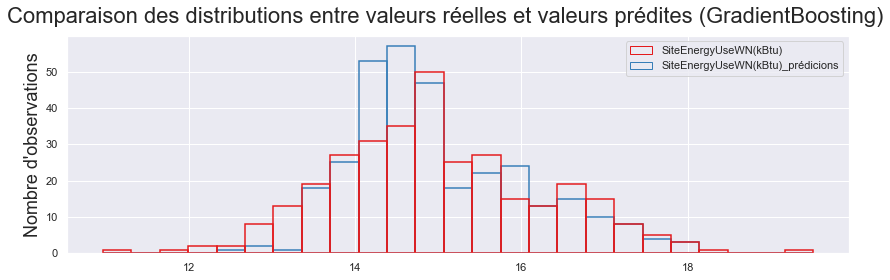

In [73]:
fig = plt.figure(figsize=(14,4))
fig.suptitle('Comparaison des distributions entre valeurs réelles et valeurs prédites (GradientBoosting)', size=22)
sns.histplot(data=exp, fill=False, palette="Set1")
plt.ylabel("Nombre d'observations")    
plt.show()

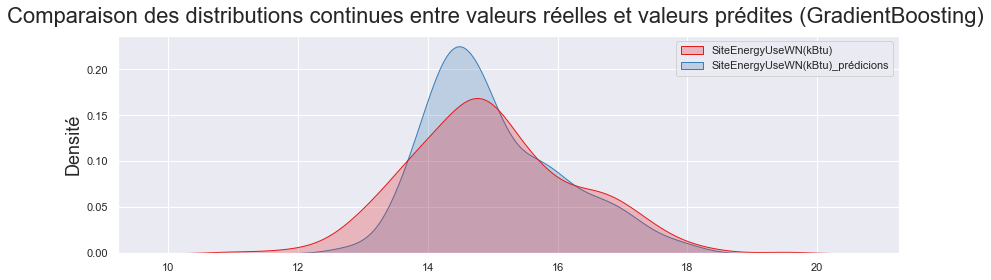

In [74]:
fig = plt.figure(figsize=(14,4))
fig.suptitle('Comparaison des distributions continues entre valeurs réelles et valeurs prédites (GradientBoosting)', size=22)
sns.kdeplot(data=exp, fill=True, palette="Set1")
plt.ylabel('Densité')    
plt.show()

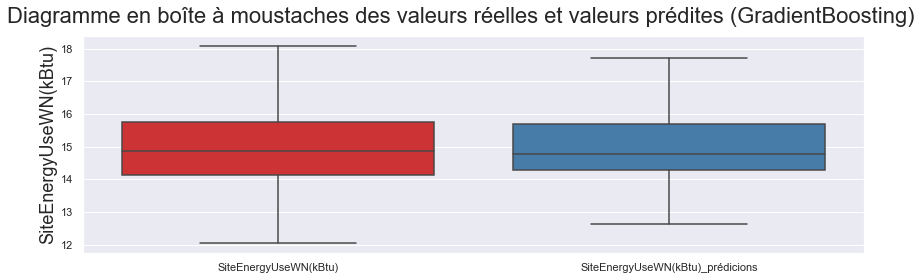

In [75]:
fig = plt.figure(figsize=(14,4))
fig.suptitle('Diagramme en boîte à moustaches des valeurs réelles et valeurs prédites (GradientBoosting)', size=22)
sns.boxplot(data=exp, palette="Set1", showfliers = False)
plt.ylabel('SiteEnergyUseWN(kBtu)')    
plt.show()

## <font color="#114b98" id="section_6">6. Cross-Validation</font>

Je divise le jeu de données dans cette validation croisée à l'aide de RepeatedKFold.

In [76]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=0)

Je crée un dictionnaire avec les 5 meilleurs régresseurs de mon analyse précédente.

In [77]:
regressors = {                   
                   'Random Forest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0),
                   'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=0),
                   'Extra Trees': ExtraTreesRegressor(n_estimators=100, n_jobs=-1, random_state=0),
                   'XGBoost': XGBRegressor(n_estimators=100, random_state=0),
                   'SupportVector': SVR()
                  }

Je crée 3 dictionnaires dans lesquels je vais enregistrer les résultats de mes tests :
 - R² sur le jeu de test
 - MAE : erreur absolue moyenne, moyenne arithmétique des valeurs absolues des écarts
 - RMSE : erreur quadratique moyenne : racine carrée de la moyenne des carrés des erreurs

In [78]:
r2_2 = {}
rmse_2 = {}
mae_2 = {}

In [79]:
for name_reg, reg in regressors.items() :
    print("----------------------------------------------------")
    print("---", name_reg, "---\n")
    
    pipeline = Pipeline([("preprocess", preparation),("regressor", reg)])

    scores = cross_validate(pipeline,
                            X,
                            y.values.ravel(),
                            cv=rkf,
                            scoring=["r2",
                                     "neg_mean_absolute_error",
                                     "neg_mean_squared_error"])
    
    print("    R²")
    r2_2[name_reg] = scores['test_r2']
    print("\t - Moyenne : {:.3f}".format(r2_2[name_reg].mean()))
    print("\t - Ecart-type : {:.3f}\n".format(r2_2[name_reg].std()))

    print("    M.A.E.")
    mae_2[name_reg] = -scores["test_neg_mean_absolute_error"]
    print("\t - Moyenne : {:.3f}".format(mae_2[name_reg].mean()))
    print("\t - Ecart-type : {:.3f}\n".format(mae_2[name_reg].std()))
    
    print("    R.M.S.E.")
    rmse_2[name_reg] = np.sqrt(-scores["test_neg_mean_squared_error"])
    print("\t - Moyenne : {:.3f}".format(rmse_2[name_reg].mean()))
    print("\t - Ecart-type : {:.3f}\n".format(rmse_2[name_reg].std()))

----------------------------------------------------
--- Random Forest ---

    R²
	 - Moyenne : 0.748
	 - Ecart-type : 0.017

    M.A.E.
	 - Moyenne : 0.466
	 - Ecart-type : 0.021

    R.M.S.E.
	 - Moyenne : 0.639
	 - Ecart-type : 0.016

----------------------------------------------------
--- Gradient Boosting ---

    R²
	 - Moyenne : 0.769
	 - Ecart-type : 0.015

    M.A.E.
	 - Moyenne : 0.451
	 - Ecart-type : 0.027

    R.M.S.E.
	 - Moyenne : 0.612
	 - Ecart-type : 0.024

----------------------------------------------------
--- Extra Trees ---

    R²
	 - Moyenne : 0.754
	 - Ecart-type : 0.013

    M.A.E.
	 - Moyenne : 0.455
	 - Ecart-type : 0.021

    R.M.S.E.
	 - Moyenne : 0.632
	 - Ecart-type : 0.015

----------------------------------------------------
--- XGBoost ---

    R²
	 - Moyenne : 0.770
	 - Ecart-type : 0.014

    M.A.E.
	 - Moyenne : 0.451
	 - Ecart-type : 0.022

    R.M.S.E.
	 - Moyenne : 0.611
	 - Ecart-type : 0.017

------------------------------------------------

In [80]:
average = 0
print("Moyennes des R²\n")
for array in r2_2:
    average = average + r2_2[array].mean()
    print(round(r2_2[array].mean(), 3))

Moyennes des R²

0.748
0.769
0.754
0.77
0.74


In [81]:
def graphical_display(results, title) :
    # Fonction qui permet d'afficher un barplot des résultats : moyenne et écart-type
    x = list(results)
    y = np.array(list(results.values()))
    score_mean = [score.mean() for score in np.array(list(results.values()))]
    score_std = [score.std() for score in np.array(list(results.values()))]
    
    palette = sns.color_palette('pastel')
    colors = palette[0: len(results)]

    fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(14,6))
    fig.suptitle(title, fontsize=22)
    axs[0].bar(x=x, height=score_mean, color=colors)
    axs[0].set_ylabel("Mean")
    axs[0].errorbar(range(len(score_mean)), score_mean, yerr=score_std, fmt='none', ecolor='black')
    axs[1].bar(x=x, height=score_std, color=colors)
    axs[1].set_ylabel("Variance")

    plt.show()

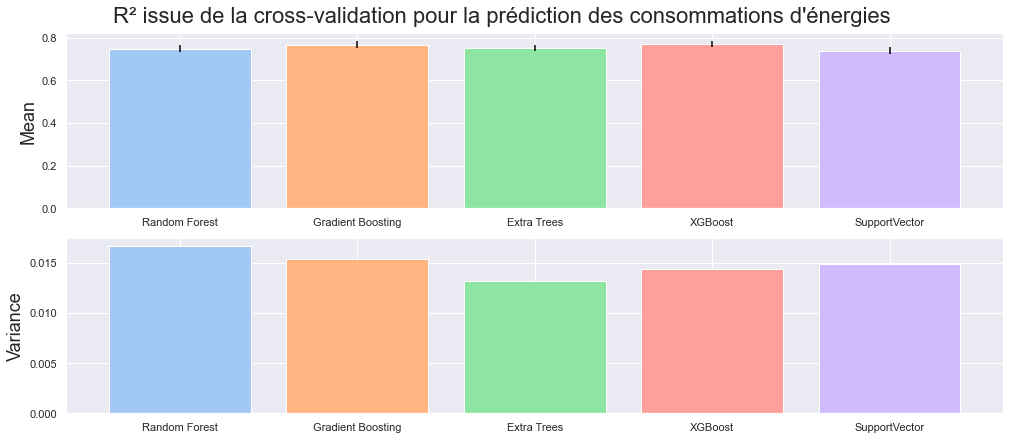

In [82]:
graphical_display(r2_2, "R² issue de la cross-validation pour la prédiction des consommations d'énergies")

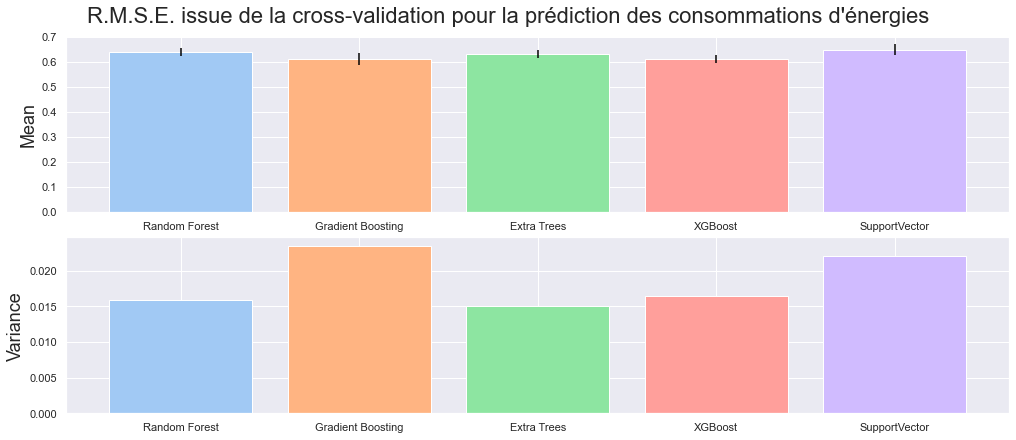

In [83]:
graphical_display(rmse_2, "R.M.S.E. issue de la cross-validation pour la prédiction des consommations d'énergies")

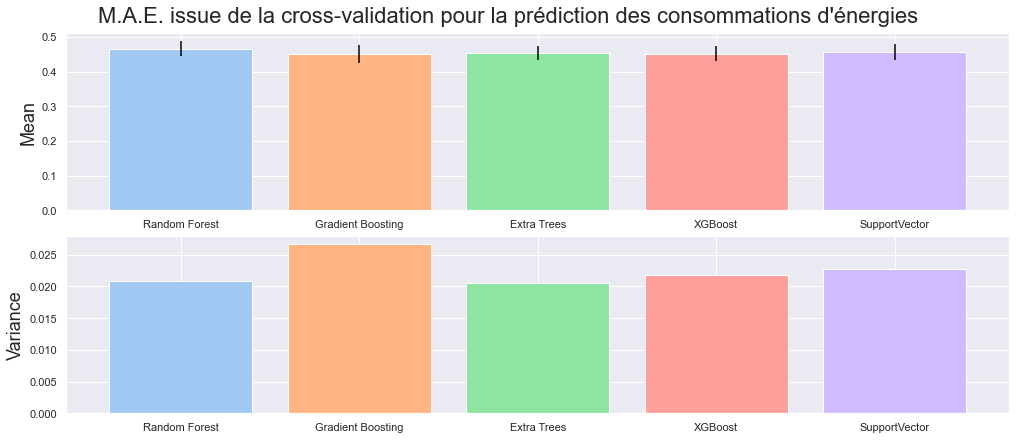

In [84]:
graphical_display(mae_2, "M.A.E. issue de la cross-validation pour la prédiction des consommations d'énergies")

Les trois meilleurs regresseurs (plus faible variance et meilleurs R²) sont :
 - 'Gradient Boosting'
 - 'Random Forrest'
 - 'XGBoost'

Je vais donc utiliser ces trois regresseurs et les hyperparamétrer.

## <font color="#114b98" id="section_7">7. Hyperparamétrage</font>

In [85]:
# Dictionnaire de regresseurs
regressors_2 = {   
                   'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=0),
                   'Random Forrest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0),
                   'XGBoost': XGBRegressor(n_estimators=100, random_state=0)
                }

Je crée un dictionnaire des GridSearch afin de conserver tous les résultats.

In [86]:
grid_search_results = {}

In [87]:
def grid_search(regressors, pipeline, param_grid, X, y, n_splits, n_repeats, display=True) :
    
    """
    Optimise une liste d'estimateurs et retourne le meilleur
    regressors(dict): Dictionnaire d'estimateurs
    pipeline : pipeline de transformation de données
    param_grid(dict) : dictionnaire de dictionnaires de paramètres
    X(np.array): jeux de données
    y(np.array): prédiction
    
    """
    
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=0)
    
    grid_search_dict = {}
    
    # Meilleur score
    best_score = float('inf')
    
    # Dictionnaire des modèles hyperparamétrés
    rmse_mean = {}
    rmse_std = {}

    for name_reg, regressor in regressors.items() :
        print("-------------------------------------------------------")
        print("---", name_reg, "---\n")
        prepare_select_and_predict_pipeline = Pipeline([("preprocess", preparation),("regressor", regressor)])

    
        grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline,
                                             param_grid[name_reg],
                                             scoring='neg_mean_squared_error',
                                             cv=rkf)
        
        # Entrainement du modèle
        grid_search_prep.fit(X, y)
        
        # Sauvegarde du modèle
        grid_search_dict[name_reg] = grid_search_prep
        
        best_model_index = grid_search_prep.best_index_
        score = [np.sqrt(-grid_search_prep.cv_results_["split" + str(i) + "_test_score"][best_model_index])
                 for i in range(n_splits)]
        
        # Moyenne et écart-type de la RMSE
        mean_score, std_score = np.mean(score), np.std(score)
        rmse_mean[name_reg], rmse_std[name_reg] = mean_score, std_score
        score = grid_search_prep.best_estimator_.score(X, y)
        
        print("Paramètres du meilleur modèle : \n")
        for params, values in grid_search_prep.best_params_.items():
             print("\t - ", params, ":", values)
        print("\nRésultats :")
        print("\n\t - R² score sur le jeu d'entrainement : {:.3f}".format(score))
        print("\t - Mean of RMSE : {:.3f}".format(mean_score))
        print("\t - Ecart-type : {:.3f}\n".format(std_score))
        
        if mean_score < best_score :
            best_score = mean_score
            best_model = grid_search_prep.best_estimator_
            
    return grid_search_dict

In [88]:
# Hyperparamères pour les modèles ensemblistes d'arbres de regression
param_grid_reg_tree = {
    'regressor__n_estimators': range(260,300,20), # Nombre d'arbres
    'regressor__max_depth': range(4, 24, 4), # Nombre de profondeurs maximums
    'regressor__max_features': range(24, 40, 4) # Nombre de maximum de features
}

# Ajout du paramètre learning rate pour le Gradient Boosting
param_grid_gb = param_grid_reg_tree.copy()
param_grid_gb["regressor__learning_rate"] = [0.01,0.05,0.1]
                                             
# Ajout des paramètres pour le XGBoost
param_grid_xgb = {
    'regressor__n_estimators': [125,150,175],
    'regressor__learning_rate': [0.01,0.05,0.1],
    'regressor__booster' : ['gbtree','gblinear'],
}

# Dictionnaire de grille de paramètres
param_grid = {
              'Gradient Boosting': param_grid_gb,
              'Random Forrest': param_grid_reg_tree,
              'XGBoost': param_grid_xgb,
             }

In [89]:
# Selection du meilleur modèle
grid_search_results["SiteEnergyUseWN(kBtu)"] = grid_search(regressors_2, 
                                                           preparation,
                                                           param_grid,
                                                           X,
                                                           y.values.ravel(),
                                                           n_splits = 5,
                                                           n_repeats = 2)

-------------------------------------------------------
--- Gradient Boosting ---

Paramètres du meilleur modèle : 

	 -  regressor__learning_rate : 0.05
	 -  regressor__max_depth : 4
	 -  regressor__max_features : 32
	 -  regressor__n_estimators : 280

Résultats :

	 - R² score sur le jeu d'entrainement : 0.899
	 - Mean of RMSE : 0.604
	 - Ecart-type : 0.017

-------------------------------------------------------
--- Random Forrest ---

Paramètres du meilleur modèle : 

	 -  regressor__max_depth : 20
	 -  regressor__max_features : 32
	 -  regressor__n_estimators : 280

Résultats :

	 - R² score sur le jeu d'entrainement : 0.963
	 - Mean of RMSE : 0.631
	 - Ecart-type : 0.021

-------------------------------------------------------
--- XGBoost ---

Paramètres du meilleur modèle : 

	 -  regressor__booster : gbtree
	 -  regressor__learning_rate : 0.05
	 -  regressor__n_estimators : 175

Résultats :

	 - R² score sur le jeu d'entrainement : 0.906
	 - Mean of RMSE : 0.596
	 - Ecart-type 

## <font color="#114b98" id="section_8">8. Choix du meilleur modèle</font>

In [90]:
regressors_3 = {          
                   'Gradient Boosting': GradientBoostingRegressor(n_estimators=280, 
                                                                  max_features=32,
                                                                  max_depth=4,
                                                                  learning_rate=0.05,
                                                                  random_state=0),
    
    
                   'Random Forrest': RandomForestRegressor(n_estimators=280, 
                                                           max_features=32,
                                                           max_depth=20,
                                                           n_jobs=-1, 
                                                           random_state=0),
    
                   'XGBoost': XGBRegressor(n_estimators=175, 
                                           learning_rate=0.05,
                                           booster='gbtree',
                                           random_state=0) 
                  }

In [91]:
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)

In [92]:
r2_3 = {}
rmse_3 = {}
mae_3 = {}

In [93]:
for name_reg, reg in regressors_3.items() :
    print("----------------------------------------------------")
    print("---", name_reg, "---\n")
    
    pipeline = Pipeline([("preprocess", preparation),("regressor", reg)])

    scores = cross_validate(pipeline,
                            X,
                            y.values.ravel(),
                            cv=rkf,
                            scoring=["r2",
                                     "neg_mean_absolute_error",
                                     "neg_mean_squared_error"])
    
    print("    R²")
    r2_3[name_reg] = scores['test_r2']
    print("\t - Moyenne : {:.3f}".format(r2_3[name_reg].mean()))
    print("\t - Ecart-type : {:.3f}\n".format(r2_3[name_reg].std()))

    print("    M.A.E.")
    mae_3[name_reg] = -scores["test_neg_mean_absolute_error"]
    print("\t - Moyenne : {:.3f}".format(mae_3[name_reg].mean()))
    print("\t - Ecart-type : {:.3f}\n".format(mae_3[name_reg].std()))
    
    print("    R.M.S.E.")
    rmse_3[name_reg] = np.sqrt(-scores["test_neg_mean_squared_error"])
    print("\t - Moyenne : {:.3f}".format(rmse_3[name_reg].mean()))
    print("\t - Ecart-type : {:.3f}\n".format(rmse_3[name_reg].std()))

----------------------------------------------------
--- Gradient Boosting ---

    R²
	 - Moyenne : 0.777
	 - Ecart-type : 0.018

    M.A.E.
	 - Moyenne : 0.442
	 - Ecart-type : 0.019

    R.M.S.E.
	 - Moyenne : 0.601
	 - Ecart-type : 0.027

----------------------------------------------------
--- Random Forrest ---

    R²
	 - Moyenne : 0.755
	 - Ecart-type : 0.015

    M.A.E.
	 - Moyenne : 0.460
	 - Ecart-type : 0.016

    R.M.S.E.
	 - Moyenne : 0.631
	 - Ecart-type : 0.025

----------------------------------------------------
--- XGBoost ---

    R²
	 - Moyenne : 0.780
	 - Ecart-type : 0.018

    M.A.E.
	 - Moyenne : 0.439
	 - Ecart-type : 0.018

    R.M.S.E.
	 - Moyenne : 0.597
	 - Ecart-type : 0.025



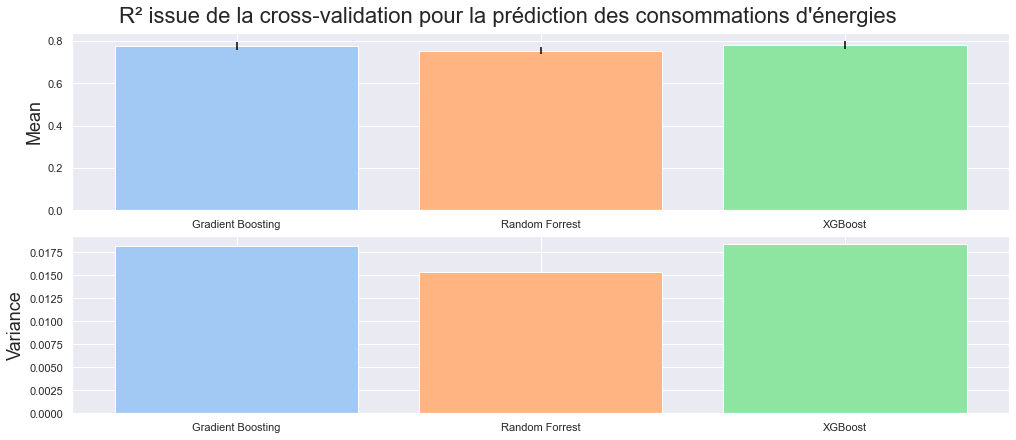

In [94]:
graphical_display(r2_3, "R² issue de la cross-validation pour la prédiction des consommations d'énergies")

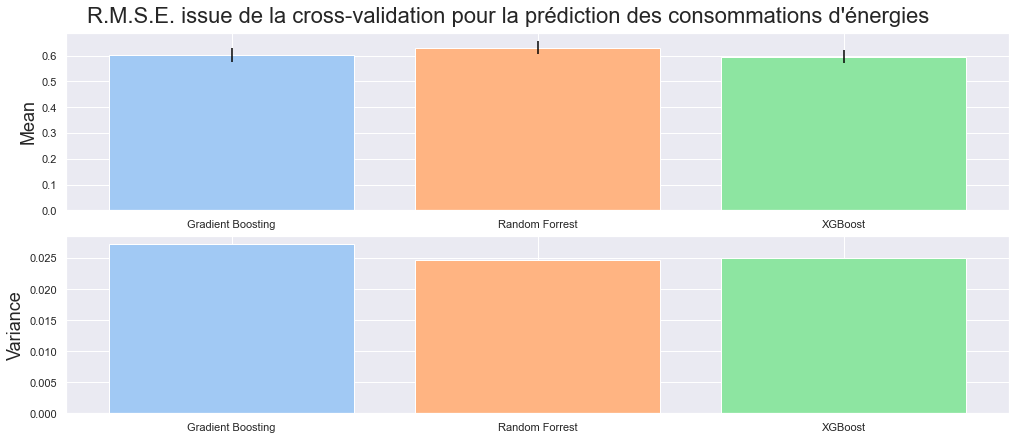

In [95]:
graphical_display(rmse_3, "R.M.S.E. issue de la cross-validation pour la prédiction des consommations d'énergies")

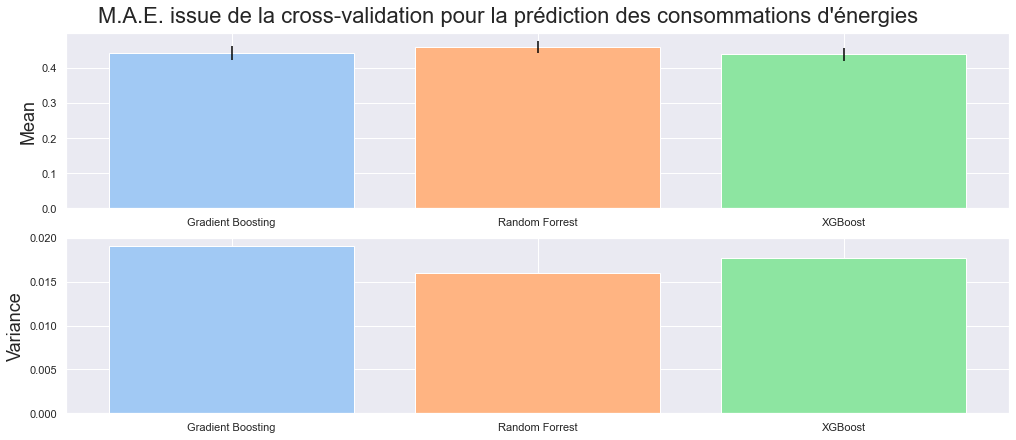

In [96]:
graphical_display(mae_3, "M.A.E. issue de la cross-validation pour la prédiction des consommations d'énergies")

**Conclusion : J'obiens les meilleurs scores avec XGBoost. R² = 0,78**

In [97]:
final_model = {}

In [98]:
final_model['SiteEnergyUseWN(kBtu)'] = grid_search_results['SiteEnergyUseWN(kBtu)']['XGBoost'].best_estimator_

In [99]:
final_model

{'SiteEnergyUseWN(kBtu)': Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('quantitative',
                                                   Pipeline(steps=[('standard',
                                                                    StandardScaler())]),
                                                   ['NumberofFloors',
                                                    'PropertyGFATotal',
                                                    'PropertyGFAParking',
                                                    'ElectricityProp',
                                                    'NaturalGasProp',
                                                    'SteamUseProp',
                                                    'BuildingAge',
                                                    'Adult Education',
                                                    'Automobile Dealership',
                                                    'Bank Branch',


## <font color="#114b98" id="section_9">9. SHAP : SHapley Additive exPlanations</font>

In [100]:
print("SHAP Version : {}".format(shap.__version__))

SHAP Version : 0.41.0


In [101]:
shap.initjs()

In [102]:
X = data[data.drop(['SiteEnergyUseWN(kBtu)'], axis=1).columns]

In [103]:
y = data[['SiteEnergyUseWN(kBtu)']]

In [104]:
X_transfo = preparation.fit_transform(X)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_transfo, y, train_size=0.8, random_state=42)

In [106]:
model_XGBoost = XGBRegressor(n_estimators=175, 
                             learning_rate=0.05,
                             booster='gbtree',
                             verbosity = 0,
                             random_state=0) 

In [107]:
explainer = shap.TreeExplainer(model_XGBoost.fit(X_train, y_train.values.ravel()))

In [108]:
X_importance = X_test[:]

In [109]:
shap_values = explainer.shap_values(X_importance)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [110]:
df = pd.DataFrame(np.zeros, 
                  index = data.drop(['SiteEnergyUseWN(kBtu)'], axis=1).columns.to_list(),
                  columns = ['a'])

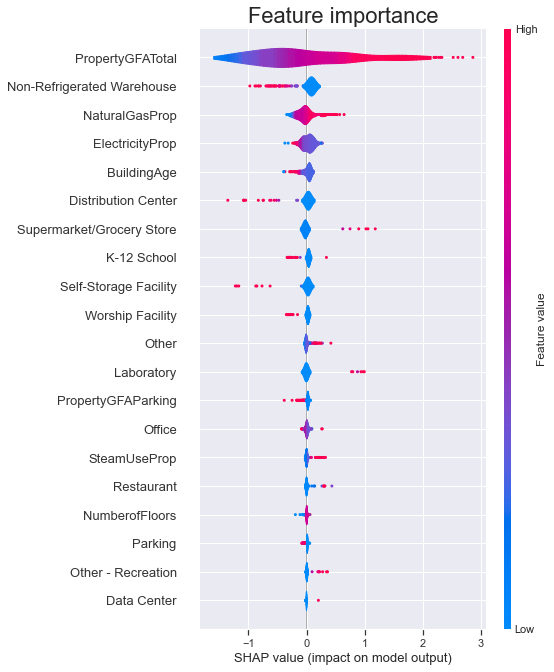

In [111]:
plt.title('Feature importance')
shap.summary_plot(shap_values, X_importance, feature_names=df.index,
                  plot_type="violin",
                  color="tomato")

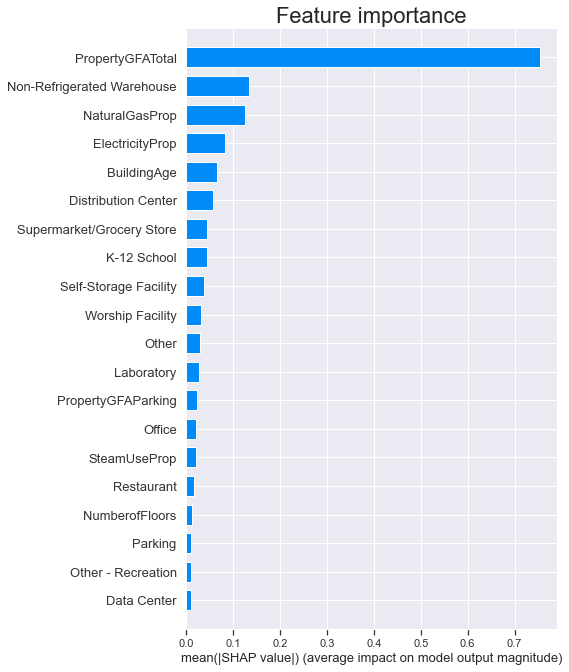

In [112]:
plt.title('Feature importance')
shap.summary_plot(shap_values, X_importance, plot_type='bar', feature_names=df.index)

## <font color="#114b98" id="section_10">10. Exemple de prédictions de consommation d'énergie</font>

In [113]:
# Fonction pour la transformation inverse sur nos variables à prédire
f = lambda x : np.exp(x) - 1

Je vais sélectionner 100 bâtiments pour vérifier la qualité du modèle.

In [114]:
X_transfo = preparation.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transfo, y, train_size=0.8, random_state=42)

In [115]:
y_true = y_test.apply(f)
y_true.reset_index(inplace = True, drop = True)
y_true = y_true[100:200]
#y_true.reset_index(inplace = True, drop = True)

In [116]:
y_pred = pd.DataFrame(model_XGBoost.predict(X_test), columns=['SiteEnergyUseWN(kBtu)'])
y_pred = y_pred.apply(f)
y_pred = y_pred[100:200]
#y_pred.reset_index(inplace = True, drop = True)

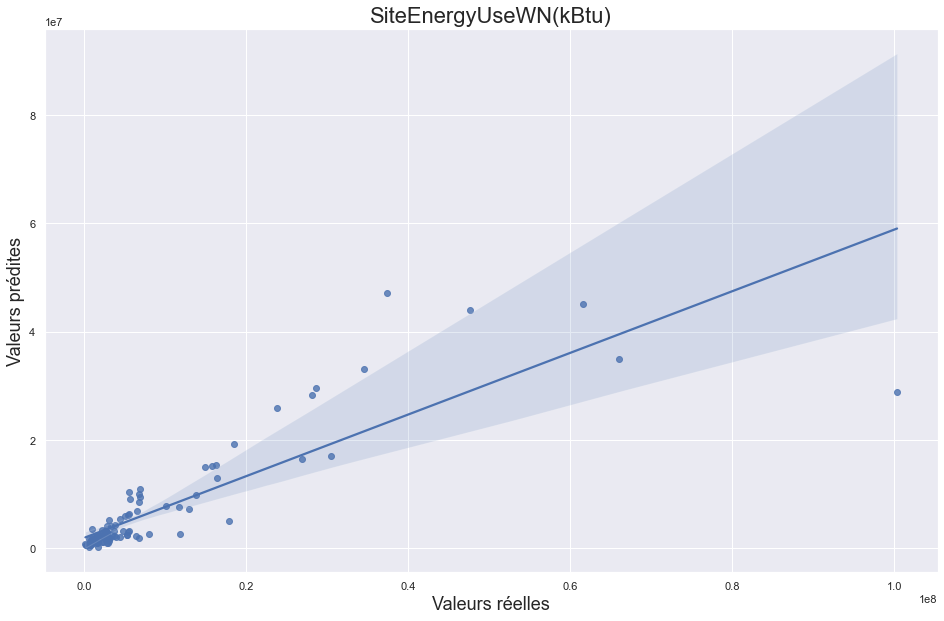

In [117]:
fig = plt.figure(1, figsize=(16,10))

sns.regplot(x=y_true,y=y_pred)
plt.title('SiteEnergyUseWN(kBtu)')
plt.xlabel("Valeurs réelles");
plt.ylabel("Valeurs prédites");

Le modèle est peu efficace pour la prédiction des bâtiments à haute consommation d'énergie (supérieure à 1e7 kBtu).

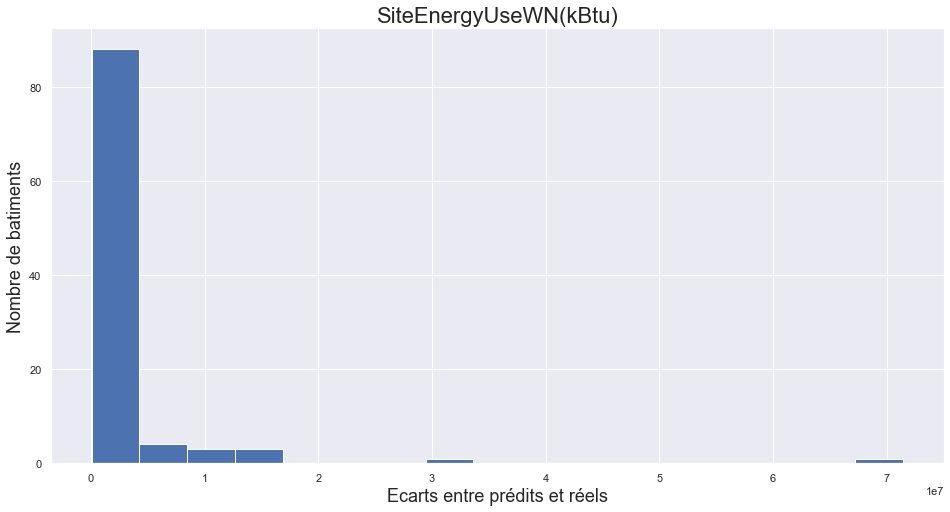

In [118]:
# Histogramme de l'écart entre valeurs prédites et valeurs réelles
fig = plt.figure(figsize=(16,8))
plt.title("SiteEnergyUseWN(kBtu)")
plt.xlabel("Ecarts entre prédits et réels")
plt.ylabel("Nombre de batiments")
values = abs(y_pred["SiteEnergyUseWN(kBtu)"] - y_true["SiteEnergyUseWN(kBtu)"])
plt.hist(values, bins=int(1 + np.log2(len(y_test))*2))
plt.show()

En revanche, le modèle est performant pour les bâtiments à faible consommation.